# Libraries and Data

In [1]:
# Libraries and Data Load

import numpy as np
import pandas as pd
import os
pd.set_option('display.max_colwidth', None)  # Show full content of columns

# Visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

# Feature extraction (vectorization)
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE # Addressing class imbalances

# Train-test split
from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

#####

# Load the cleaned data
df = pd.read_csv("../data/cleaned_data.csv")

# Logistic regression: Run and Optimization

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Logistic Regression Results (with Resampled Data):
              precision    recall  f1-score   support

    Negative       0.60      0.71      0.65     16402
     Neutral       0.26      0.61      0.36      8528
    Positive       0.96      0.80      0.87     88756

    accuracy                           0.77    113686
   macro avg       0.60      0.70      0.63    113686
weighted avg       0.85      0.77      0.80    113686



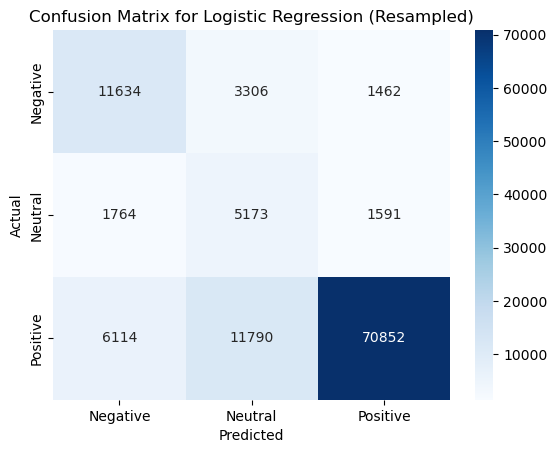

In [2]:
# Data Preparation

# Features (cleaned text) and target (sentiment)

X = df['cleaned_text']  # Features
y = df['Sentiment']     # Target

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Replace NaN values with an empty string
X_train = X_train.fillna("")
X_test = X_test.fillna("")

# TF-IDF vectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Use unigrams and bigrams

# Fit and transform training data, transform test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE on the TF-IDF-transformed training data
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Logistic Regression

# Train Logistic Regression with resampled data
lr_model_resampled = LogisticRegression(max_iter=1000, random_state=42)
lr_model_resampled.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict on the test set
y_pred_lr = lr_model_resampled.predict(X_test_tfidf)

# Evaluate
print("Logistic Regression Results (with Resampled Data):")
print(classification_report(y_test, y_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model_resampled.classes_, yticklabels=lr_model_resampled.classes_)
plt.title("Confusion Matrix for Logistic Regression (Resampled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
44 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py", 

Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best F1-Score: 0.7651151330555012
Logistic Regression Results (after GridSearch):
              precision    recall  f1-score   support

    Negative       0.59      0.71      0.65     16402
     Neutral       0.26      0.61      0.36      8528
    Positive       0.96      0.80      0.87     88756

    accuracy                           0.77    113686
   macro avg       0.60      0.70      0.63    113686
weighted avg       0.85      0.77      0.80    113686



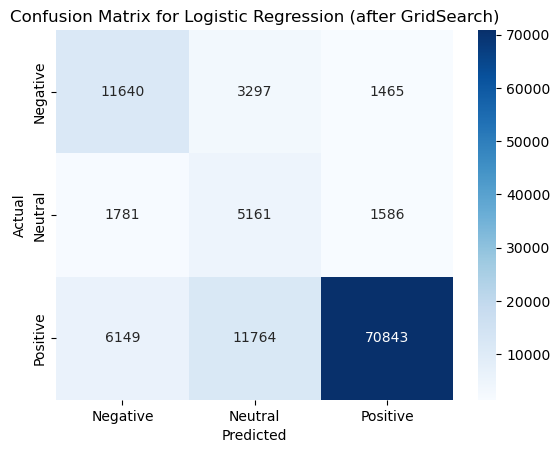

In [4]:
# Hyperparameter Tuning: Grid Search

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # Use 'l2' regularization, the most common and robust option
    'solver': ['saga', 'lbfgs'],  # Solvers that work with 'l2' penalty
    'max_iter': [100, 200, 500]  # Number of iterations
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(multi_class='multinomial', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Optimize for F1 macro average
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress during grid search
    n_jobs=-1  # Use all available cores
)

# Perform grid search
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Evaluate on test set with the best model
best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_tfidf)

# Classification report
print("Logistic Regression Results (after GridSearch):")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for Logistic Regression (after GridSearch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Compared to the base model there was not improvement, event precision for the class negative decreased from 0.6 to 0.59.
# Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}


# Light GBM: Run and Optimization



In [2]:
# Step 1: Load the cleaned data
df = pd.read_csv("../data/cleaned_data.csv")

X = df['cleaned_text']  # Features
y = df['Sentiment']     # Target

# Step 2: Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Replace NaN values with an empty string
X_train = X_train.fillna("")
X_test = X_test.fillna("")

# Step 4: TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Use unigrams and bigrams
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 5: Handle class imbalance with SMOTE (optional)
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Step 6: Map string labels to numeric
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
y_train_resampled = y_train_resampled.map(label_mapping)
y_test = y_test.map(label_mapping)

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.648289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822202
[LightGBM] [Info] Number of data points in the train set: 1065063, number of used features: 5000
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Results:
              precision    recall  f1-score   support

    Negative       0.52      0.51      0.52     16402
     Neutral       0.24      0.43      0.31      8528
    Positive       0.89      0.83      0.86     88756

    accuracy                           0.75    113686
   macro avg       0.55      0.59      0.56    113686
weighted avg       0.79      0.75      0.77    113686



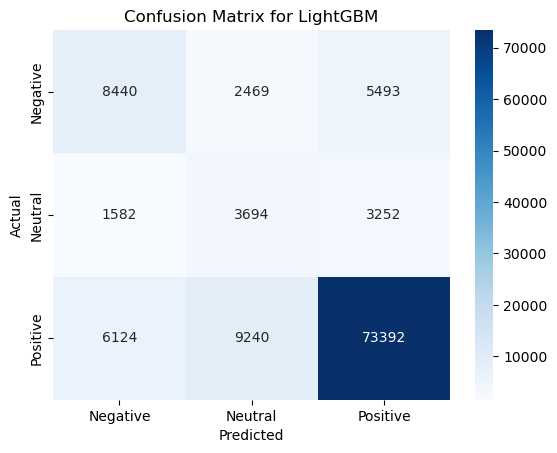

In [3]:
# Step 7: Define the LightGBM model
lgb_model = LGBMClassifier(
    n_estimators=50,    # Number of trees
    max_depth=6,        # Maximum depth of each tree
    learning_rate=0.1,  # Shrinkage step size
    random_state=42,    # For reproducibility
    n_jobs=-1           # Use all CPU cores for training
)

# Step 8: Train the LightGBM model
lgb_model.fit(X_train_tfidf_resampled, y_train_resampled)

# Step 9: Predict on the test set
y_pred_lgb = lgb_model.predict(X_test_tfidf)

# Step 10: Evaluate the model
print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgb, target_names=['Negative', 'Neutral', 'Positive']))

# Step 11: Confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# Step 12: Plot the confusion matrix
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [4]:
# Hyperparameter Tuning: Grid Search

# Define the LightGBM model
lgbm_model = LGBMClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [-1, 10],
    'min_data_in_leaf': [20, 50],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Use macro F1 to balance performance across classes
    cv=3,
    verbose=3,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_lgbm = grid_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test_tfidf)

# Classification report
print("LightGBM Results (after GridSearch):")
print(classification_report(y_test, y_pred_lgbm, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Plot confusion matrix
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix for LightGBM (after GridSearch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Stop at 329 mins

c:\Users\alexa\anaconda3\envs\sentiment_reviews_jan25\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


KeyboardInterrupt: 